In [ ]:
# ==========================================================
# 1. IMPORTS
# ==========================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report


from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")



# ==========================================================
# 2. LOAD DATA
# ==========================================================
df = pd.read_csv("train_dataset.csv")
target = "smoking"

print("Original dataset:", df.shape)



# ==========================================================
# STEP 3 — REMOVE DUPLICATES
# ==========================================================
duplicates = df.duplicated().sum()
print("Duplicate rows found:", duplicates)

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)



# ==========================================================
# 8. DBSCAN OUTLIER REMOVAL
# ==========================================================
scaler_db = StandardScaler()
X_scaled = scaler_db.fit_transform(df_imp[num_cols])

db = DBSCAN(eps=2.2, min_samples=15)  # tuned for smoker dataset
labels = db.fit_predict(X_scaled)

df_clean = df_imp[labels != -1].copy()

print("After DBSCAN outlier removal:", df_clean.shape)



# ==========================================================
# 9. TRAIN / TEST SPLIT
# ==========================================================
X = df_clean.drop(columns=[target])
y = df_clean[target]

numeric_cols = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocess = ColumnTransformer([
    ('scale', StandardScaler(), numeric_cols)
])











Original dataset: (38984, 23)
Duplicate rows found: 5517
After removing duplicates: (33467, 23)
After DBSCAN outlier removal: (23864, 23)


In [ ]:
# ==========================================================
# 10. LOGISTIC REGRESSION (BEST VERSION)
# ==========================================================
log_model = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(
        solver='lbfgs',
        C=1.0,
        max_iter=2500,
        class_weight='balanced'
    ))
])

log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print("\n===== Logistic Regression (BEST) =====")
print("Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))


===== Logistic Regression (BEST) =====
Accuracy: 0.745233605698722
              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79      3184
         1.0       0.58      0.82      0.68      1589

    accuracy                           0.75      4773
   macro avg       0.74      0.76      0.73      4773
weighted avg       0.79      0.75      0.75      4773



In [ ]:
# ==========================================================
# 11. SVM (RBF) — BEST VERSION
# ==========================================================
svm_model = Pipeline([
    ('preprocess', preprocess),
    ('clf', SVC(
        kernel='rbf',
        C=4,
        gamma=0.03,
        class_weight='balanced',
        probability=True
    ))
])

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("\n===== SVM (RBF) — BEST VERSION =====")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))


===== SVM (RBF) — BEST VERSION =====
Accuracy: 0.7391577624135763
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77      3184
         1.0       0.57      0.91      0.70      1589

    accuracy                           0.74      4773
   macro avg       0.75      0.78      0.73      4773
weighted avg       0.81      0.74      0.75      4773



In [ ]:


# ==========================================================
# 12. NEURAL NETWORK (MLP) — BEST VERSION
# ==========================================================
nn_model = Pipeline([
    ('preprocess', preprocess),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        alpha=0.0005,
        early_stopping=True,
        validation_fraction=0.15,
        max_iter=2000,
        random_state=37
    ))
])

nn_model.fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)

print("\n===== Neural Network (MLP) — BEST VERSION =====")
print("Accuracy:", accuracy_score(y_test, nn_pred))
print(classification_report(y_test, nn_pred))



# ==========================================================
# END
# ==========================================================



===== Neural Network (MLP) — BEST VERSION =====
Accuracy: 0.7678608841399539
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      3184
         1.0       0.65      0.64      0.65      1589

    accuracy                           0.77      4773
   macro avg       0.74      0.74      0.74      4773
weighted avg       0.77      0.77      0.77      4773



In [ ]:
# ==========================================================
# 11. SVM (RBF) — WITH DBSCAN + HYPERPARAMETER TUNING
# ==========================================================
from sklearn.model_selection import GridSearchCV

# Use the same preprocessing as Logistic & NN
preprocess = ColumnTransformer([
    ('scale', StandardScaler(), numeric_cols)
])

svm_pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', SVC(class_weight='balanced'))
])

# Hyperparameter search grid
param_grid = {
    'clf__C': [0.5, 1, 2, 4, 6, 8, 10, 12],
    'clf__gamma': [0.001, 0.01, 0.02, 0.04, 0.08],
    'clf__kernel': ['rbf']
}

# GridSearchCV (tunes only SVM)
grid = GridSearchCV(
    svm_pipe,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Fit on DBSCAN-cleaned dataset
grid.fit(X_train, y_train)

print("\n===== Best SVM Parameters (From GridSearch + DBSCAN) =====")
print(grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Best model
svm_best = grid.best_estimator_

# Predict on test set
svm_pred = svm_best.predict(X_test)

print("\n===== SVM (RBF) — TUNED WITH DBSCAN =====")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))



===== Best SVM Parameters (From GridSearch + DBSCAN) =====
{'clf__C': 2, 'clf__gamma': 0.08, 'clf__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7436486847032553

===== SVM (RBF) — TUNED WITH DBSCAN =====
Accuracy: 0.7469097003980725
              precision    recall  f1-score   support

         0.0       0.91      0.69      0.78      3184
         1.0       0.58      0.86      0.69      1589

    accuracy                           0.75      4773
   macro avg       0.74      0.77      0.74      4773
weighted avg       0.80      0.75      0.75      4773



In [ ]:
# ============================================
# BASIC IMPORTS
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ============================================
# LOAD DATA
# ============================================
df = pd.read_csv("train_dataset.csv")
target = "smoking"

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (38984, 23)


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [ ]:
# Data types & non-null counts
print("\n=== INFO ===")
print(df.info())

# Summary statistics
print("\n=== DESCRIPTIVE STATISTICS ===")
display(df.describe())

# Count missing values
print("\n=== MISSING VALUES ===")
print(df.isna().sum())



=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           3

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,...,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000
mean,44.127591,164.689488,65.938718,82.062115,1.014955,1.008768,1.025369,1.026190,121.475631,75.994408,...,57.293146,115.081495,14.624264,1.086523,0.886030,26.198235,27.145188,39.905038,0.214421,0.367279
std,12.063564,9.187507,12.896581,9.326798,0.498527,0.493813,0.157246,0.159703,13.643521,9.658734,...,14.617822,42.883163,1.566528,0.402107,0.220621,19.175595,31.309945,49.693843,0.410426,0.482070
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,...,47.000000,91.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,...,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,26.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,66.000000,136.000000,15.800000,1.000000,1.000000,29.000000,31.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000



=== MISSING VALUES ===
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


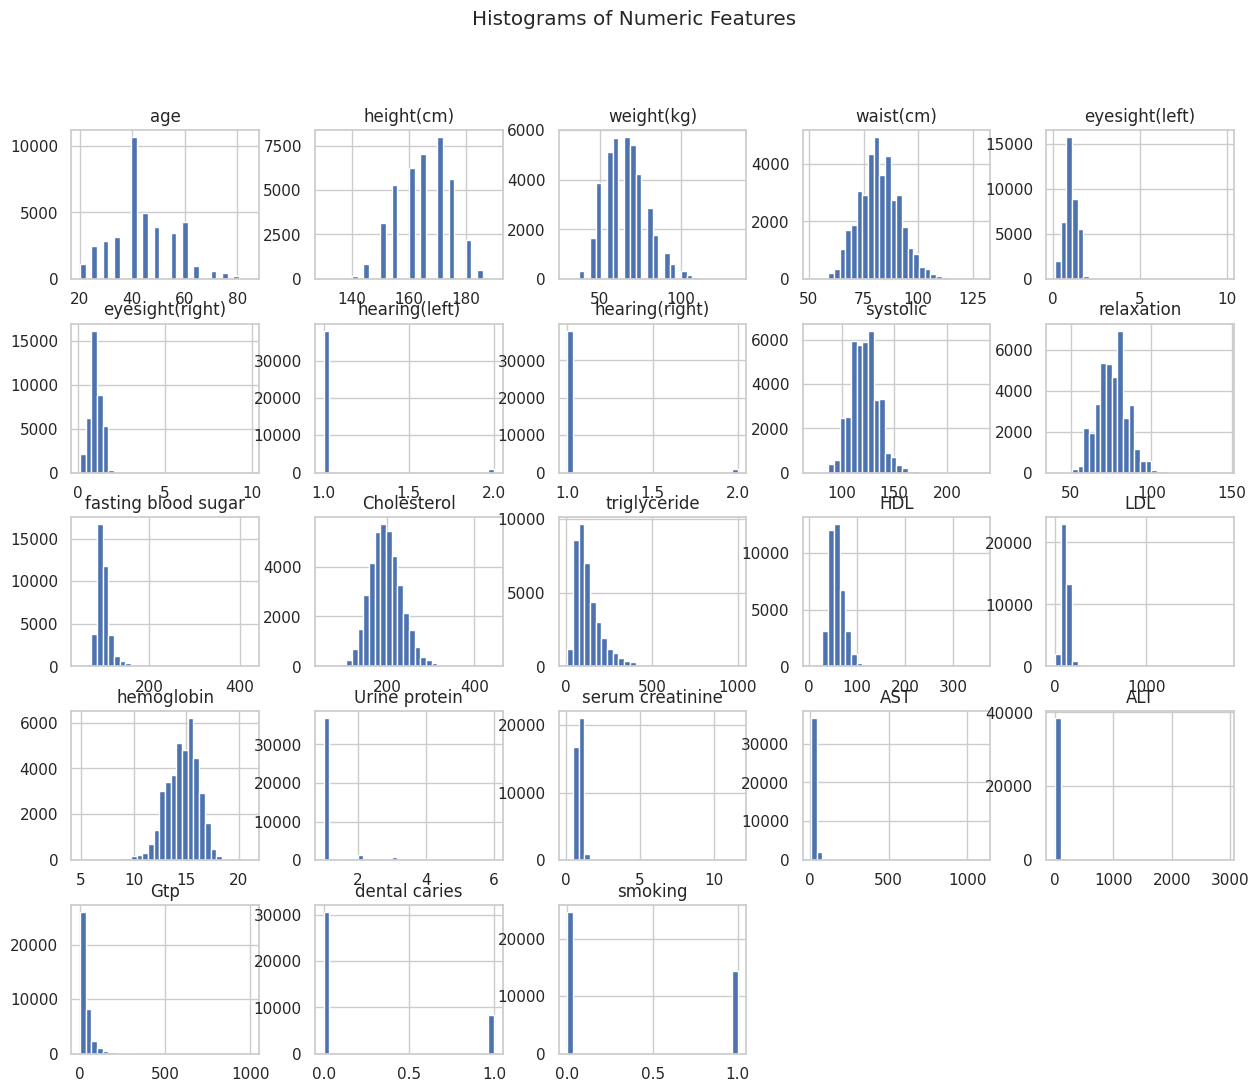

In [ ]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

df[numeric_cols].hist(figsize=(15,12), bins=30)
plt.suptitle("Histograms of Numeric Features")
plt.show()


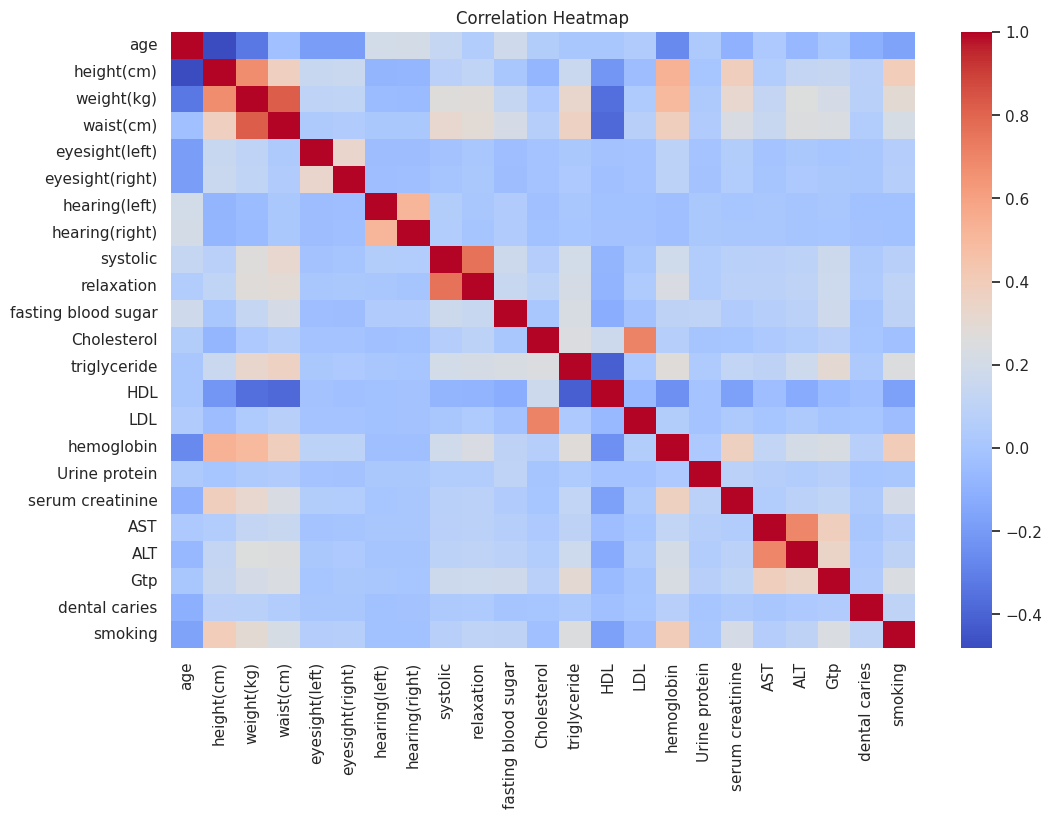

In [ ]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


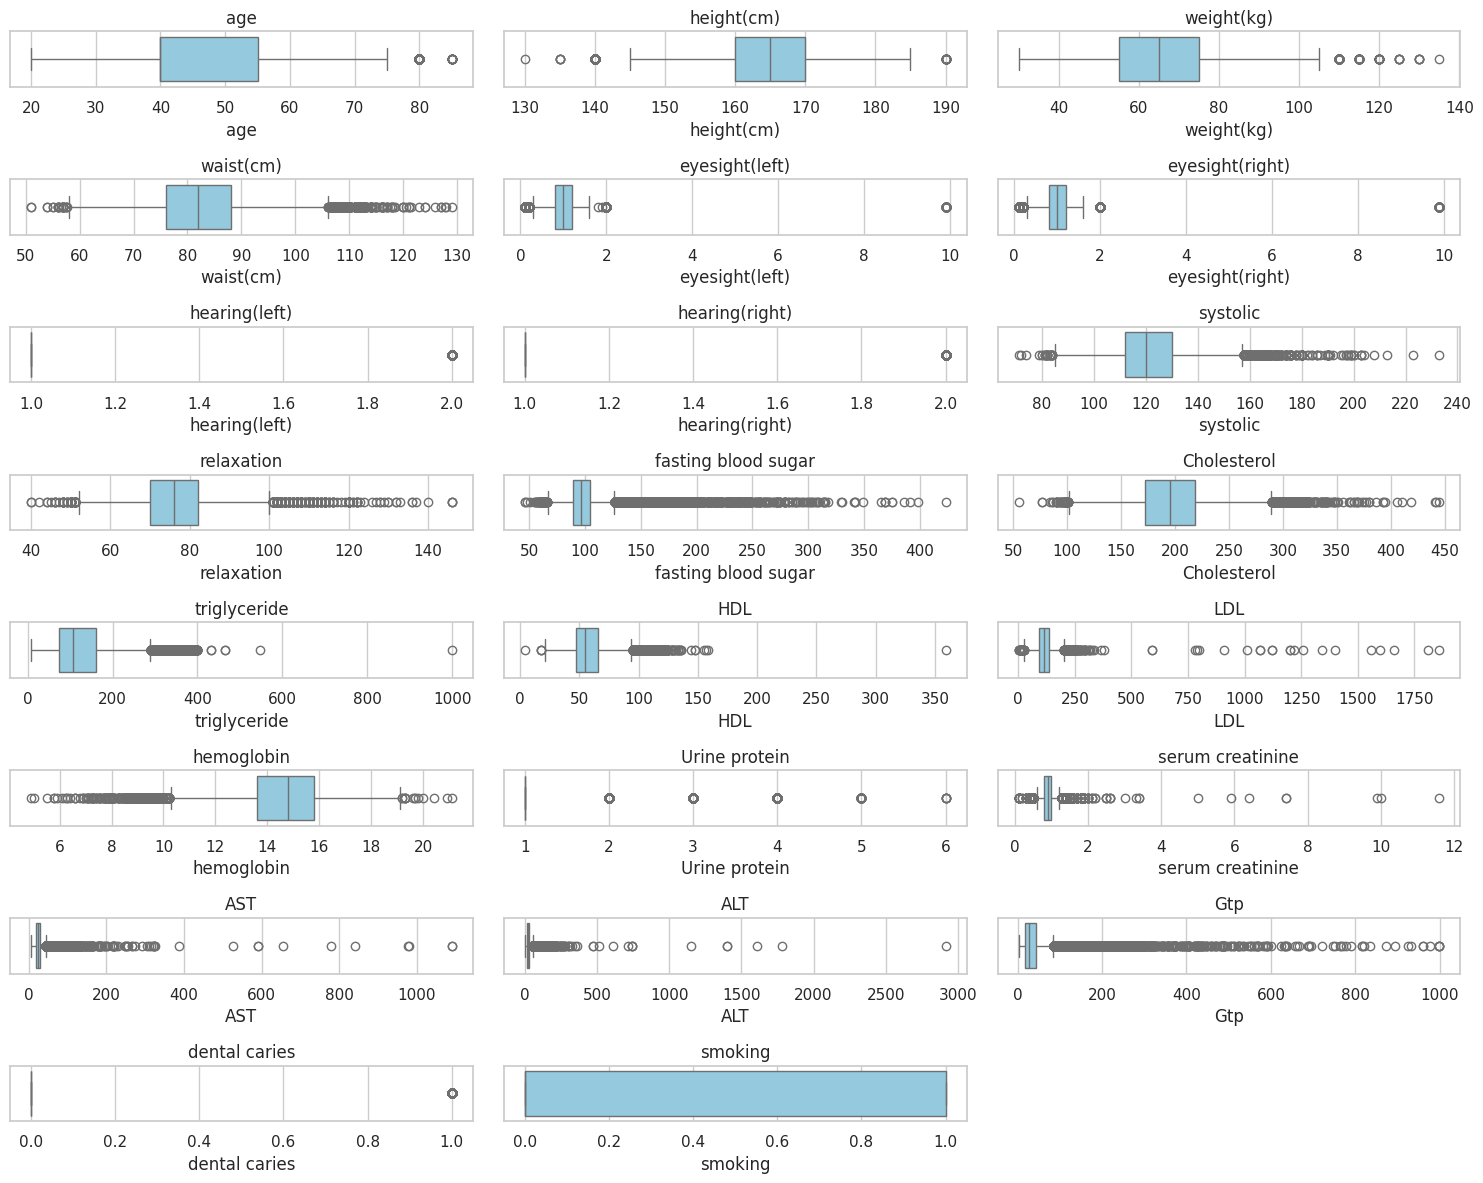

In [ ]:
plt.figure(figsize=(15,12))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i+1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col)

plt.tight_layout()
plt.show()


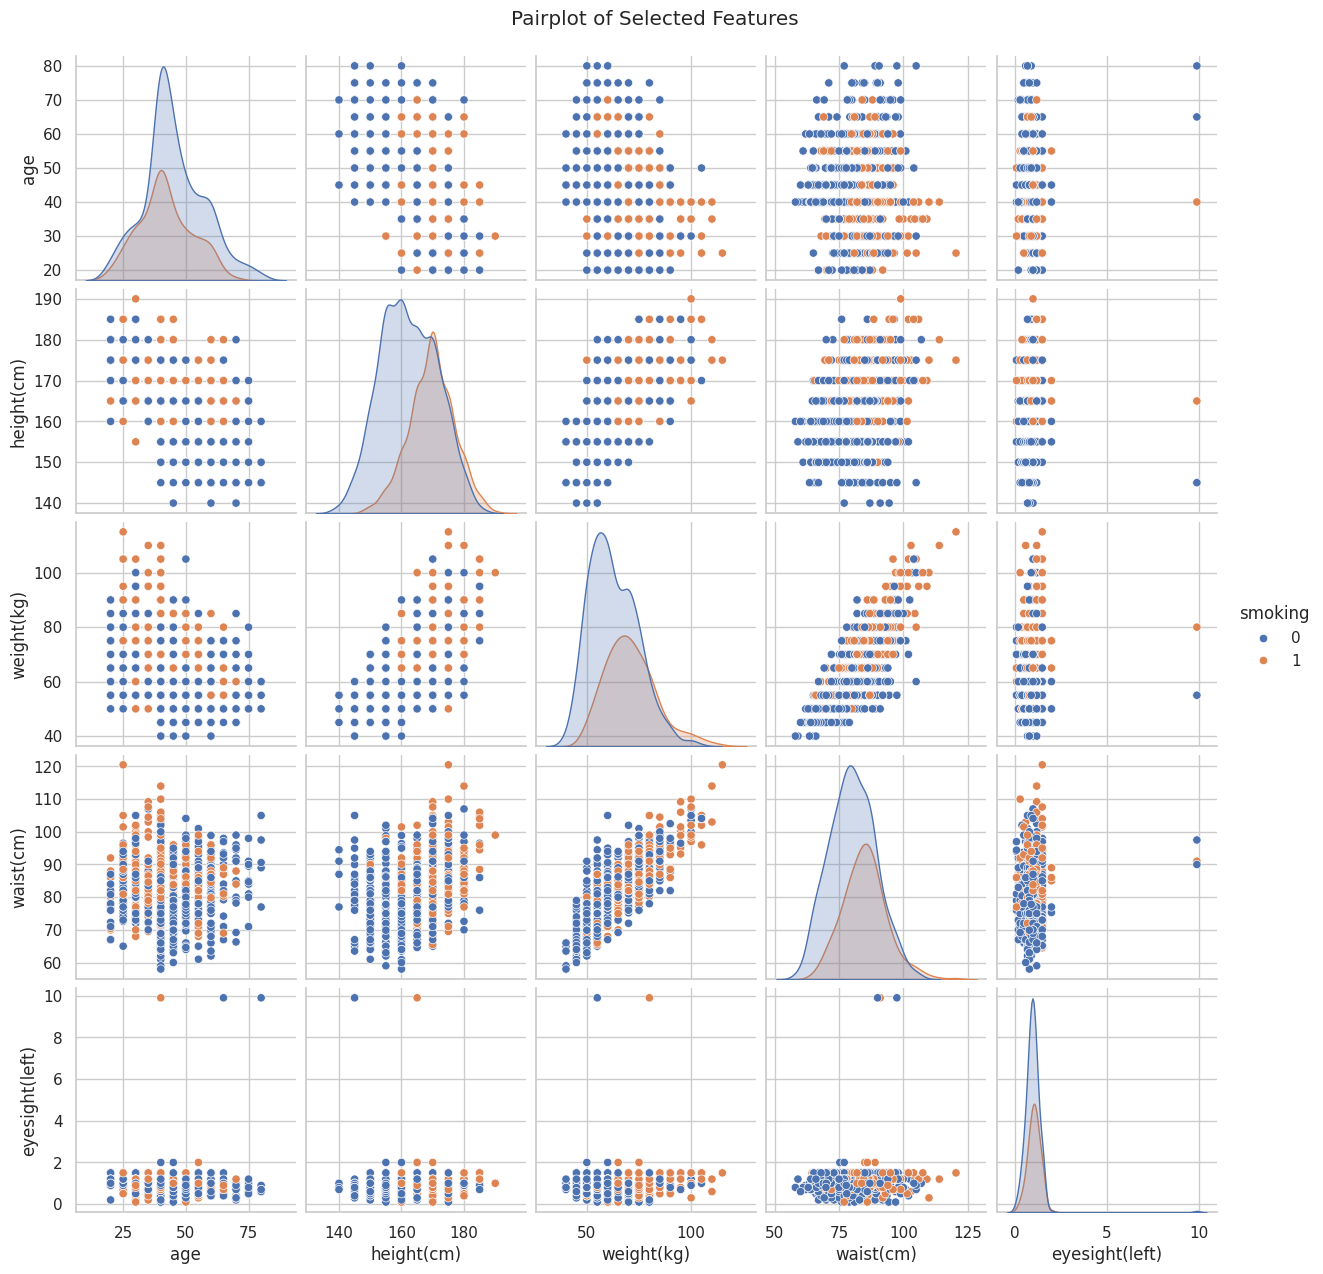

In [ ]:
sample_df = df.sample(1000, random_state=42)

sns.pairplot(sample_df[numeric_cols[:5] + [target]], hue=target)
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()


In [ ]:
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)


Duplicate rows: 5517


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Smoker (0)', 'Smoker (1)'],
                yticklabels=['Non-Smoker (0)', 'Smoker (1)'])
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


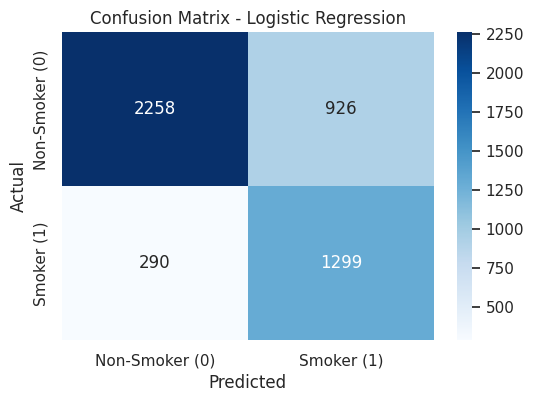

In [ ]:
plot_cm(y_test, log_pred, "Logistic Regression")


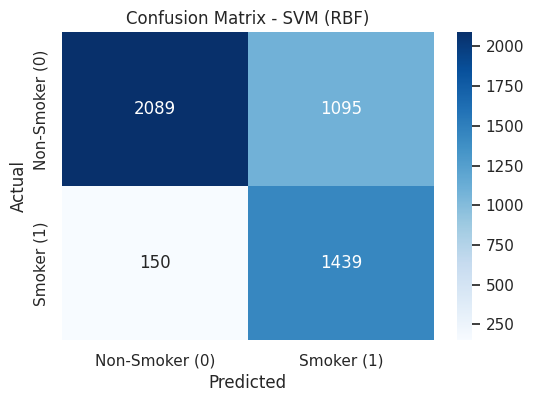

In [ ]:
plot_cm(y_test, svm_pred, "SVM (RBF)")


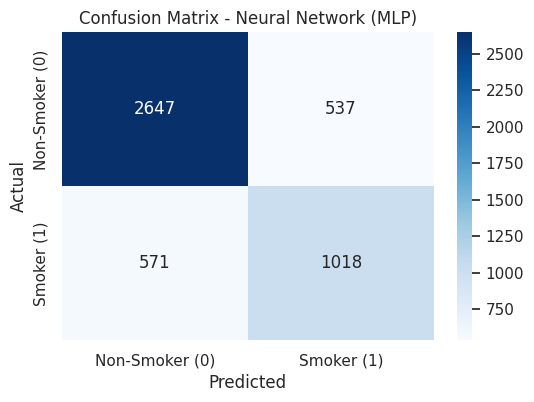

In [ ]:
plot_cm(y_test, nn_pred, "Neural Network (MLP)")


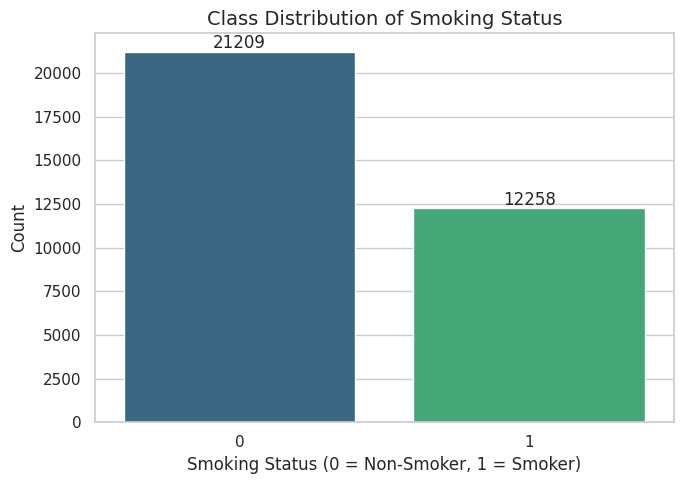

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

plt.figure(figsize=(7,5))

sns.countplot(x=df['smoking'], palette='viridis')

plt.title("Class Distribution of Smoking Status", fontsize=14)
plt.xlabel("Smoking Status (0 = Non-Smoker, 1 = Smoker)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Annotate bars with counts
counts = df['smoking'].value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, count + 200, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


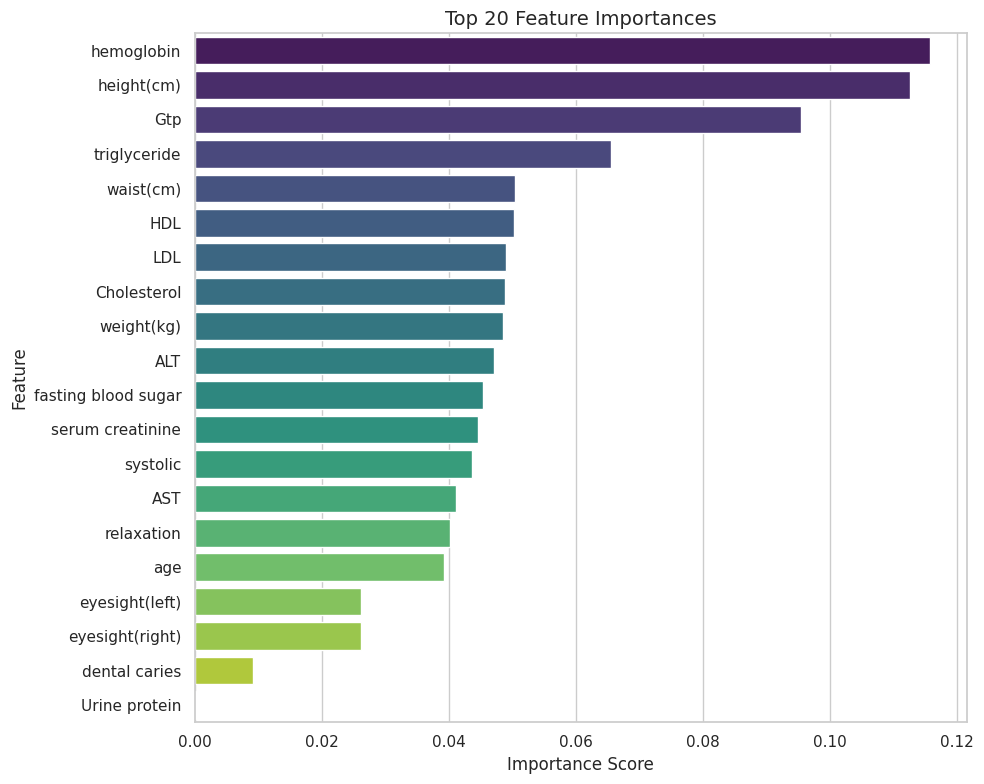

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Train a quick RandomForest ONLY for feature importance visualization
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Get importance values
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feat_imp.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)

plt.title("Top 20 Feature Importances", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

plt.show()


In [ ]:
## Comparative Analysis of Models

#A comparison of the three machine learning models—Logistic Regression, Support Vector Machine (RBF), and the Multilayer Perceptron (MLP)—highlights how each algorithm behaves on the smoker classification dataset. Logistic Regression provides a strong linear baseline and achieves stable performance with good recall for the smoker class, mainly because class_weight='balanced' compensates for the dataset’s class imbalance. However, its linear nature limits its ability to capture deeper non-linear patterns in biochemical and anthropometric features.

#The SVM with an RBF kernel performs differently: even without tuning, it achieves the highest recall for smokers, making it especially suitable for screening tasks where missing a smoker (false negative) is more critical than incorrectly labeling a non-smoker. After hyperparameter tuning, SVM becomes more balanced, improving precision while retaining strong recall, which shows that SVM performance is highly sensitive to C and gamma values.

#The MLP outperforms both models in terms of overall accuracy and weighted F1-score. Its multi-layer architecture and non-linear activations allow it to learn complex relationships among features such as triglycerides, liver enzymes, HDL, and waist measurements. Although less interpretable, the MLP delivers the most consistent performance across all metrics, showing that the dataset benefits from non-linear modeling. In summary, SVM excels at detecting smokers (high recall), MLP provides the best overall performance, and Logistic Regression remains the most interpretable option for understanding biomarker contributions.
